# Visual Anomaly Detection System for Industrial Components 
###  Precision Manufacturing: Detecting Defects

In [8]:
# Environment Setup & Dependencies

# Install required libraries (suppress verbose output)
#%pip install -q torch torchvision torchaudio
#%pip install -q timm scikit-learn pandas matplotlib seaborn

# Import core libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import timm

# Import utility libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
import random
from PIL import Image

# Verify GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB')

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print("\n✅ Environment setup complete!")

Using device: cuda
GPU: NVIDIA RTX A2000 8GB Laptop GPU
Memory Available: 8.59 GB

✅ Environment setup complete!


📁 Verifying dataset structure...
Categories found: 15
Categories: ['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']

📊 Dataset Statistics:
--------------------------------------------------------------------------------
bottle          | Train:  209 | Test Normal:  20 | Test Anomaly:  63 | Anomaly Types: 3
cable           | Train:  224 | Test Normal:  58 | Test Anomaly:  92 | Anomaly Types: 8
capsule         | Train:  219 | Test Normal:  23 | Test Anomaly: 109 | Anomaly Types: 5
carpet          | Train:  280 | Test Normal:  28 | Test Anomaly:  89 | Anomaly Types: 5
grid            | Train:  264 | Test Normal:  21 | Test Anomaly:  57 | Anomaly Types: 5
hazelnut        | Train:  391 | Test Normal:  40 | Test Anomaly:  70 | Anomaly Types: 4
leather         | Train:  245 | Test Normal:  32 | Test Anomaly:  92 | Anomaly Types: 5
metal_nut       | Train:  220 | Test Normal:  22 | Test An

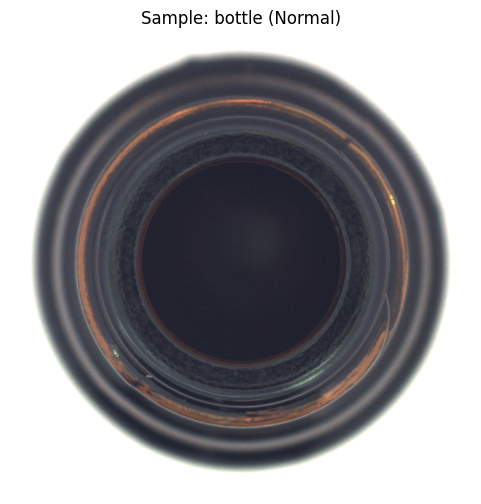

Image size: (900, 900)

✅ Dataset preparation complete!
Dataset path: C:\Users\gopeami\OneDrive - Vesuvius\Desktop\PhD13- 2025-2026\ML Practice\Industry anomaly\mvtec-ad
⏰ Completed at: 2025-11-06 12:46:12


In [9]:
# Dataset Preparation (Kaggle Input)

import os
from pathlib import Path
from datetime import datetime

# Use Kaggle input directory (dataset must be added as input)

DATA_DIR = Path('C:/Users/gopeami/OneDrive - Vesuvius/Desktop/PhD13- 2025-2026/ML Practice/Industry anomaly/mvtec-ad')

# If not using input, uncomment below to download:
# DATA_DIR = Path('/kaggle/working/mvtec_ad')
# !kaggle datasets download -d ipythonx/mvtec-ad -p {DATA_DIR} --unzip

# Verify dataset structure
print("📁 Verifying dataset structure...")
if not DATA_DIR.exists():
    raise FileNotFoundError(
        f"❌ Dataset not found at {DATA_DIR}\n"
        "Add 'ipythonx/mvtec-ad' as input in Kaggle Notebook settings"
    )

categories = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(DATA_DIR / d)])
print(f"Categories found: {len(categories)}")
print(f"Categories: {categories}")

# Display dataset statistics for each category
print("\n📊 Dataset Statistics:")
print("-" * 80)
dataset_stats = []

for category in categories:
    category_path = DATA_DIR / category
    
    # Count train images (normal samples)
    train_path = category_path / 'train' / 'good'
    train_count = len(list(train_path.glob('*.png'))) if train_path.exists() else 0
    
    # Count test images (normal + anomalous)
    test_path = category_path / 'test'
    test_normal = len(list((test_path / 'good').glob('*.png'))) if (test_path / 'good').exists() else 0
    
    # Count anomaly types
    anomaly_types = [d.name for d in test_path.iterdir() if d.is_dir() and d.name != 'good'] if test_path.exists() else []
    test_anomaly = sum([len(list((test_path / anom).glob('*.png'))) for anom in anomaly_types])
    
    dataset_stats.append({
        'Category': category,
        'Train (Normal)': train_count,
        'Test (Normal)': test_normal,
        'Test (Anomaly)': test_anomaly,
        'Anomaly Types': len(anomaly_types)
    })
    
    print(f"{category:15s} | Train: {train_count:4d} | Test Normal: {test_normal:3d} | Test Anomaly: {test_anomaly:3d} | Anomaly Types: {len(anomaly_types)}")

# Convert to DataFrame for better visualization
stats_df = pd.DataFrame(dataset_stats)
print("\n" + "="*80)
print(f"TOTAL CATEGORIES: {len(categories)}")
print(f"TOTAL TRAIN SAMPLES: {stats_df['Train (Normal)'].sum()}")
print(f"TOTAL TEST SAMPLES: {stats_df['Test (Normal)'].sum() + stats_df['Test (Anomaly)'].sum()}")
print("="*80)

# Display sample image from first category
print(f"\n🖼️ Sample image from '{categories[0]}' category:")
sample_category = DATA_DIR / categories[0] / 'train' / 'good'
sample_images = list(sample_category.glob('*.png'))
if sample_images:
    sample_img = Image.open(sample_images[0])
    plt.figure(figsize=(6, 6))
    plt.imshow(sample_img)
    plt.title(f"Sample: {categories[0]} (Normal)")
    plt.axis('off')
    plt.show()
    print(f"Image size: {sample_img.size}")

print("\n✅ Dataset preparation complete!")
print(f"Dataset path: {DATA_DIR}")
print(f"⏰ Completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

🖼️ Visualizing samples from selected categories...


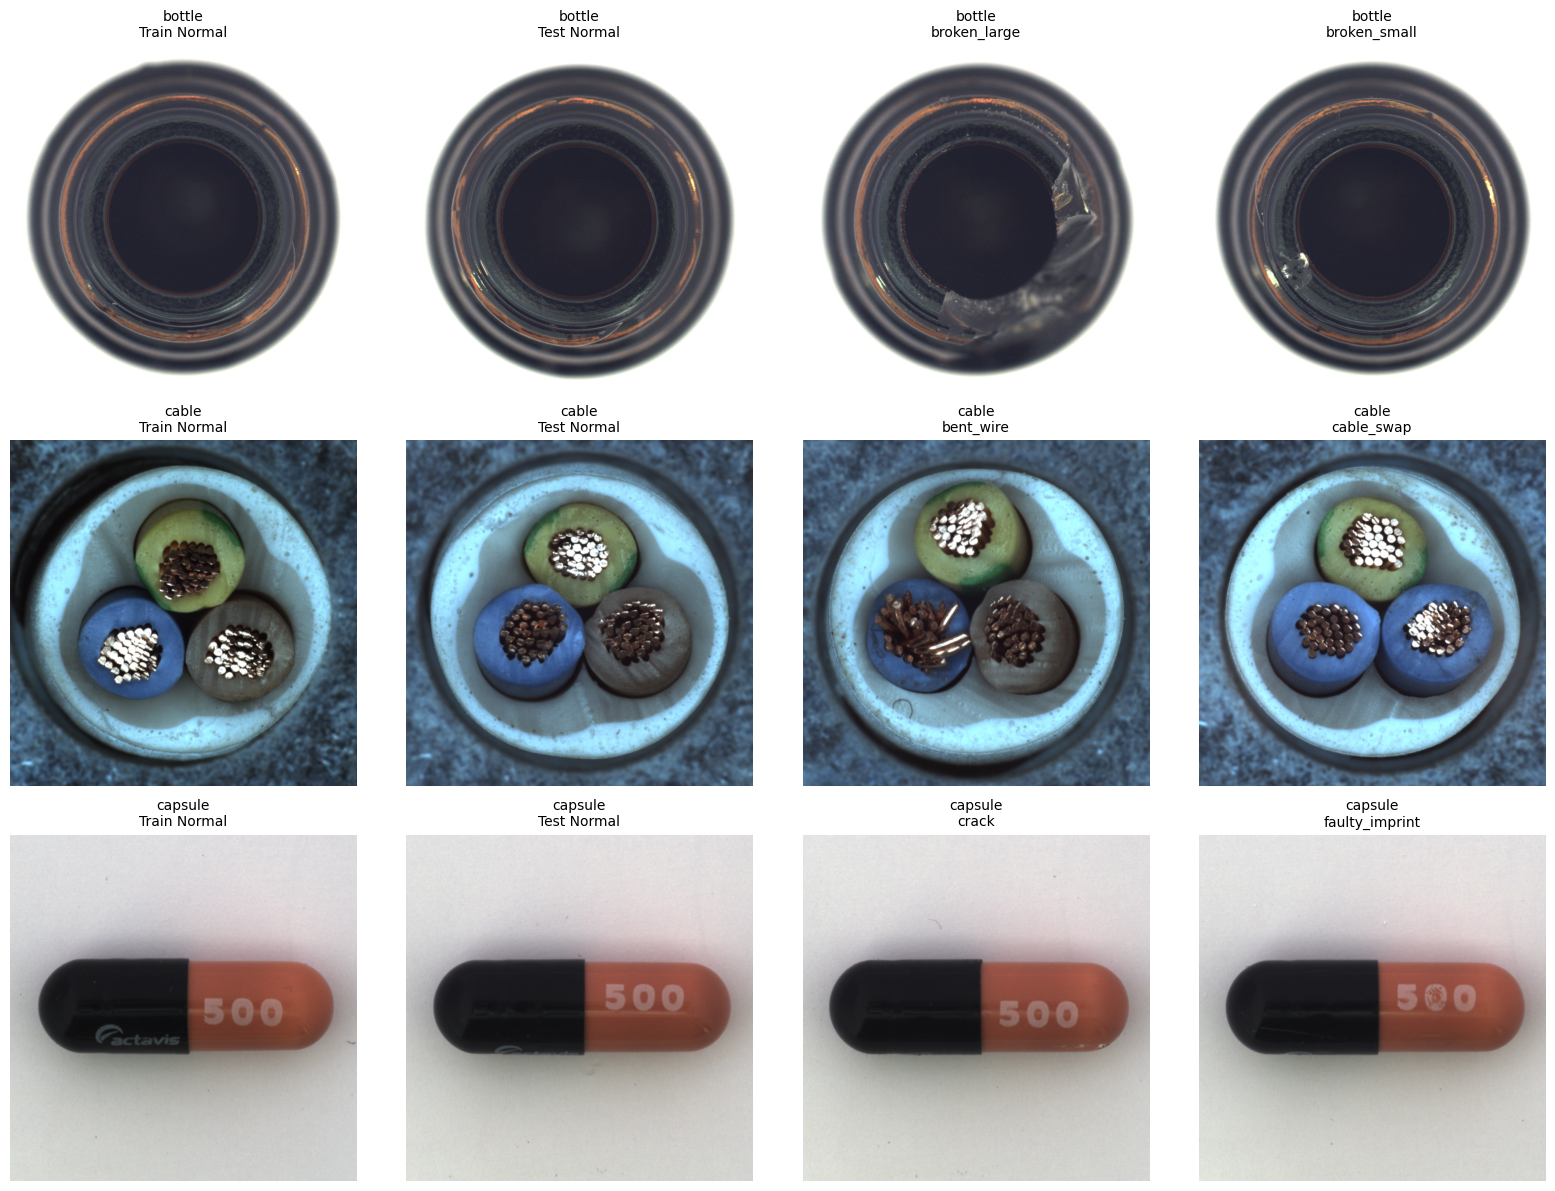


📏 Image Dimension Analysis:
--------------------------------------------------------------------------------
bottle          | 900x900 | Aspect: 1.00 | Format: RGB
cable           | 1024x1024 | Aspect: 1.00 | Format: RGB
capsule         | 1000x1000 | Aspect: 1.00 | Format: RGB
carpet          | 1024x1024 | Aspect: 1.00 | Format: RGB
grid            | 1024x1024 | Aspect: 1.00 | Format: L
hazelnut        | 1024x1024 | Aspect: 1.00 | Format: RGB
leather         | 1024x1024 | Aspect: 1.00 | Format: RGB
metal_nut       | 700x700 | Aspect: 1.00 | Format: RGB
pill            | 800x800 | Aspect: 1.00 | Format: RGB
screw           | 1024x1024 | Aspect: 1.00 | Format: L
tile            | 840x840 | Aspect: 1.00 | Format: RGB
toothbrush      | 1024x1024 | Aspect: 1.00 | Format: RGB
transistor      | 1024x1024 | Aspect: 1.00 | Format: RGB
wood            | 1024x1024 | Aspect: 1.00 | Format: RGB
zipper          | 1024x1024 | Aspect: 1.00 | Format: L

🔍 Defect Type Distribution:
--------------------

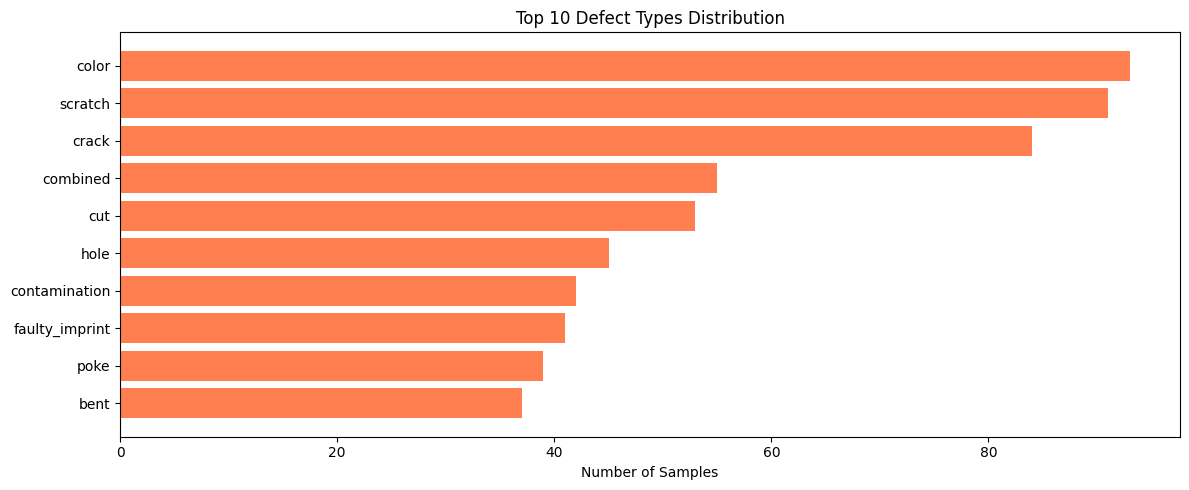


✅ Data exploration complete!
⏰ Completed at: 2025-11-06 12:46:14


In [10]:
# Data Exploration & Visualization

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Function to load sample images from a category
def load_samples(category, data_dir, n_samples=3):
    """Load normal and anomalous samples from a category"""
    samples = {'normal_train': [], 'normal_test': [], 'anomaly': {}}
    
    category_path = data_dir / category
    
    # Load training normal samples
    train_normal_path = category_path / 'train' / 'good'
    if train_normal_path.exists():
        train_images = list(train_normal_path.glob('*.png'))[:n_samples]
        samples['normal_train'] = [Image.open(img) for img in train_images]
    
    # Load test normal samples
    test_normal_path = category_path / 'test' / 'good'
    if test_normal_path.exists():
        test_images = list(test_normal_path.glob('*.png'))[:n_samples]
        samples['normal_test'] = [Image.open(img) for img in test_images]
    
    # Load anomaly samples by type
    test_path = category_path / 'test'
    if test_path.exists():
        anomaly_types = [d.name for d in test_path.iterdir() if d.is_dir() and d.name != 'good']
        for anom_type in anomaly_types[:3]:  # Limit to 3 anomaly types
            anom_images = list((test_path / anom_type).glob('*.png'))[:n_samples]
            samples['anomaly'][anom_type] = [Image.open(img) for img in anom_images[:1]]  # 1 per type
    
    return samples

# Visualize samples from multiple categories
print("🖼️ Visualizing samples from selected categories...")
selected_categories = categories[:3]  # Show first 3 categories

fig, axes = plt.subplots(len(selected_categories), 4, figsize=(16, 4*len(selected_categories)))
if len(selected_categories) == 1:
    axes = axes.reshape(1, -1)

for idx, category in enumerate(selected_categories):
    samples = load_samples(category, DATA_DIR, n_samples=1)
    
    # Column 0: Train normal
    if samples['normal_train']:
        axes[idx, 0].imshow(samples['normal_train'][0])
        axes[idx, 0].set_title(f"{category}\nTrain Normal", fontsize=10)
    axes[idx, 0].axis('off')
    
    # Column 1: Test normal
    if samples['normal_test']:
        axes[idx, 1].imshow(samples['normal_test'][0])
        axes[idx, 1].set_title(f"{category}\nTest Normal", fontsize=10)
    axes[idx, 1].axis('off')
    
    # Columns 2-3: Anomalies
    anom_col = 2
    for anom_type, images in list(samples['anomaly'].items())[:2]:
        if images:
            axes[idx, anom_col].imshow(images[0])
            axes[idx, anom_col].set_title(f"{category}\n{anom_type}", fontsize=10)
        axes[idx, anom_col].axis('off')
        anom_col += 1
    
    # Fill remaining columns if fewer than 2 anomaly types
    while anom_col < 4:
        axes[idx, anom_col].axis('off')
        anom_col += 1

plt.tight_layout()
plt.show()

# Analyze image dimensions across categories
print("\n📏 Image Dimension Analysis:")
print("-" * 80)
dimension_stats = []

for category in categories:
    category_path = DATA_DIR / category / 'train' / 'good'
    if category_path.exists():
        sample_img = Image.open(list(category_path.glob('*.png'))[0])
        width, height = sample_img.size
        dimension_stats.append({
            'Category': category,
            'Width': width,
            'Height': height,
            'Aspect Ratio': f"{width/height:.2f}",
            'Format': sample_img.mode
        })
        print(f"{category:15s} | {width}x{height} | Aspect: {width/height:.2f} | Format: {sample_img.mode}")

# Defect type distribution across all categories
print("\n🔍 Defect Type Distribution:")
print("-" * 80)
all_defect_types = {}

for category in categories:
    test_path = DATA_DIR / category / 'test'
    if test_path.exists():
        anomaly_types = [d.name for d in test_path.iterdir() if d.is_dir() and d.name != 'good']
        for anom_type in anomaly_types:
            count = len(list((test_path / anom_type).glob('*.png')))
            if anom_type not in all_defect_types:
                all_defect_types[anom_type] = 0
            all_defect_types[anom_type] += count

# Sort defect types by frequency
sorted_defects = sorted(all_defect_types.items(), key=lambda x: x[1], reverse=True)
print(f"Total unique defect types: {len(sorted_defects)}\n")
for defect, count in sorted_defects[:10]:  # Show top 10
    print(f"{defect:20s} | Count: {count:4d}")

# Visualize defect distribution
if len(sorted_defects) > 0:
    defect_names = [d[0] for d in sorted_defects[:10]]
    defect_counts = [d[1] for d in sorted_defects[:10]]
    
    plt.figure(figsize=(12, 5))
    plt.barh(defect_names, defect_counts, color='coral')
    plt.xlabel('Number of Samples')
    plt.title('Top 10 Defect Types Distribution')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

print("\n✅ Data exploration complete!")
print(f"⏰ Completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

In [11]:
# Cell 4: Configuration & Hyperparameters

from datetime import datetime
from dataclasses import dataclass, field
from typing import List, Tuple

@dataclass
class Config:
    """Configuration class for anomaly detection project"""
    
    # ===== PATHS =====
    data_dir: Path = field(default_factory=lambda: Path('C:/Users/gopeami/OneDrive - Vesuvius/Desktop/PhD13- 2025-2026/ML Practice/Industry anomaly/mvtec-ad'))
    output_dir: Path = field(default_factory=lambda: Path('C:/Users/gopeami/OneDrive - Vesuvius/Desktop/PhD13- 2025-2026/ML Practice/Industry anomaly/outputs'))
    model_dir: Path = field(default_factory=lambda: Path('C:/Users/gopeami/OneDrive - Vesuvius/Desktop/PhD13- 2025-2026/ML Practice/Industry anomaly/models'))
    results_dir: Path = field(default_factory=lambda: Path('C:/Users/gopeami/OneDrive - Vesuvius/Desktop/PhD13- 2025-2026/ML Practice/Industry anomaly/results'))

    # ===== MODEL PARAMETERS =====
    model_name: str = 'dinov2_vitb14'  # DINOv2 ViT-B/14 backbone
    feature_dim: int = 768  # DINOv2 ViT-B/14 feature dimension
    patch_size: int = 14  # DINOv2 patch size
    
    # ===== FEW-SHOT PARAMETERS =====
    k_shot: int = 4  # Number of support samples for few-shot learning
    use_few_shot: bool = True  # Enable few-shot mode
    
    # ===== IMAGE PREPROCESSING =====
    img_size: Tuple[int, int] = (224, 224)  # Input image size for DINOv2
    normalize_mean: Tuple[float, float, float] = (0.485, 0.456, 0.406)  # ImageNet mean
    normalize_std: Tuple[float, float, float] = (0.229, 0.224, 0.225)  # ImageNet std
    
    # ===== TRAINING PARAMETERS =====
    batch_size: int = 32  # Batch size for inference
    num_workers: int = 2  # DataLoader workers
    
    # ===== MEMORY BANK PARAMETERS =====
    memory_bank_size: int = None  # Auto-calculated from training samples
    distance_metric: str = 'euclidean'  # Distance metric: 'euclidean' or 'cosine'
    
    # ===== ANOMALY DETECTION PARAMETERS =====
    anomaly_threshold: float = None  # Auto-calculated from validation set
    top_k_neighbors: int = 5  # Number of nearest neighbors for scoring
    
    # ===== CATEGORIES =====
    categories: List[str] = field(default_factory=list)  # Auto-populated from dataset
    target_category: str = None  # Specific category to process (None = all)
    
    # ===== DEVICE =====
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # ===== REPRODUCIBILITY =====
    seed: int = 42
    
    # ===== LOGGING =====
    verbose: bool = True
    save_predictions: bool = True
    save_visualizations: bool = True
    
    def __post_init__(self):
        """Create directories after initialization"""
        self.output_dir.mkdir(parents=True, exist_ok=True)
        self.model_dir.mkdir(parents=True, exist_ok=True)
        self.results_dir.mkdir(parents=True, exist_ok=True)
        
        # Populate categories from dataset
        if self.data_dir.exists() and not self.categories:
            self.categories = sorted([
                d for d in os.listdir(self.data_dir) 
                if os.path.isdir(self.data_dir / d)
            ])
    
    def display(self):
        """Display configuration settings"""
        print("=" * 80)
        print("⚙️  CONFIGURATION SETTINGS")
        print("=" * 80)
        print(f"\n📁 PATHS:")
        print(f"  Data Directory:    {self.data_dir}")
        print(f"  Output Directory:  {self.output_dir}")
        print(f"  Model Directory:   {self.model_dir}")
        print(f"  Results Directory: {self.results_dir}")
        
        print(f"\n🤖 MODEL:")
        print(f"  Model Name:        {self.model_name}")
        print(f"  Feature Dimension: {self.feature_dim}")
        print(f"  Patch Size:        {self.patch_size}")
        
        print(f"\n🎯 FEW-SHOT:")
        print(f"  K-Shot:            {self.k_shot}")
        print(f"  Use Few-Shot:      {self.use_few_shot}")
        
        print(f"\n🖼️  IMAGE PROCESSING:")
        print(f"  Image Size:        {self.img_size}")
        print(f"  Normalize Mean:    {self.normalize_mean}")
        print(f"  Normalize Std:     {self.normalize_std}")
        
        print(f"\n⚡ TRAINING:")
        print(f"  Batch Size:        {self.batch_size}")
        print(f"  Num Workers:       {self.num_workers}")
        
        print(f"\n🔍 ANOMALY DETECTION:")
        print(f"  Distance Metric:   {self.distance_metric}")
        print(f"  Top K Neighbors:   {self.top_k_neighbors}")
        print(f"  Threshold:         {'Auto-calculated' if self.anomaly_threshold is None else self.anomaly_threshold}")
        
        print(f"\n📊 CATEGORIES:")
        print(f"  Total Categories:  {len(self.categories)}")
        print(f"  Target Category:   {self.target_category if self.target_category else 'All'}")
        if self.categories:
            print(f"  Categories:        {', '.join(self.categories[:5])}" + 
                  (f"... (+{len(self.categories)-5} more)" if len(self.categories) > 5 else ""))
        
        print(f"\n💻 DEVICE:")
        print(f"  Device:            {self.device}")
        if self.device == 'cuda':
            print(f"  GPU:               {torch.cuda.get_device_name(0)}")
        
        print(f"\n🎲 REPRODUCIBILITY:")
        print(f"  Seed:              {self.seed}")
        
        print("=" * 80)

# Initialize configuration
config = Config()
config.display()

print(f"\n✅ Configuration initialized!")
print(f"⏰ Completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

⚙️  CONFIGURATION SETTINGS

📁 PATHS:
  Data Directory:    C:\Users\gopeami\OneDrive - Vesuvius\Desktop\PhD13- 2025-2026\ML Practice\Industry anomaly\mvtec-ad
  Output Directory:  C:\Users\gopeami\OneDrive - Vesuvius\Desktop\PhD13- 2025-2026\ML Practice\Industry anomaly\outputs
  Model Directory:   C:\Users\gopeami\OneDrive - Vesuvius\Desktop\PhD13- 2025-2026\ML Practice\Industry anomaly\models
  Results Directory: C:\Users\gopeami\OneDrive - Vesuvius\Desktop\PhD13- 2025-2026\ML Practice\Industry anomaly\results

🤖 MODEL:
  Model Name:        dinov2_vitb14
  Feature Dimension: 768
  Patch Size:        14

🎯 FEW-SHOT:
  K-Shot:            4
  Use Few-Shot:      True

🖼️  IMAGE PROCESSING:
  Image Size:        (224, 224)
  Normalize Mean:    (0.485, 0.456, 0.406)
  Normalize Std:     (0.229, 0.224, 0.225)

⚡ TRAINING:
  Batch Size:        32
  Num Workers:       2

🔍 ANOMALY DETECTION:
  Distance Metric:   euclidean
  Top K Neighbors:   5
  Threshold:         Auto-calculated

📊 CATEGORIES

🎨 Initializing image transforms...
✓ Train transform created
✓ Test transform created

🧪 Testing data pipeline with category: bottle

📊 Dataset Statistics for 'bottle':
  Train samples: 209
  Test samples:  83
  Test normal:   20
  Test anomaly:  63

🔄 Creating DataLoaders...
  📌 Few-shot mode: Using 4 samples
✓ Train loader created: 1 batches
✓ Test  loader created: 3 batches

🖼️  Testing batch loading...
  Batch image shape: torch.Size([4, 3, 224, 224])
  Batch labels:      [0, 0, 0, 0]
  Defect types:      ['good', 'good', 'good', 'good']...


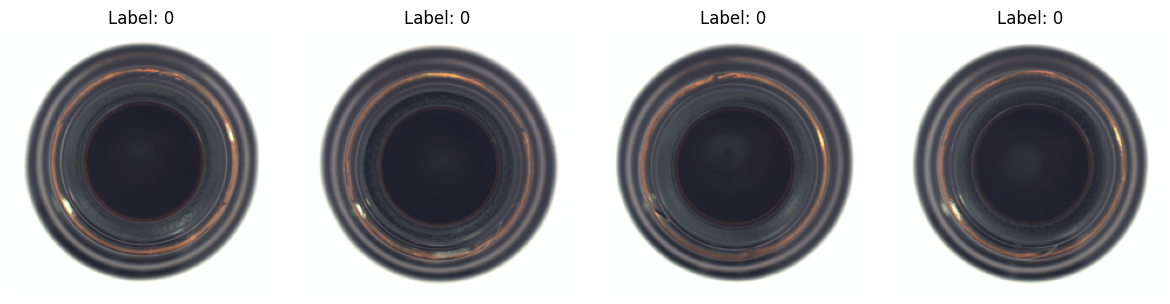


✅ Data preprocessing and loaders ready!
⏰ Completed at: 2025-11-06 12:49:19


In [13]:
# --- FIXED IMPORTS ---
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import torch
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader, Subset
from datetime import datetime

# --- helpers ---
def _glob_images(dir_path: Path):
    """Return a sorted list of image files across common extensions."""
    exts = ('*.png', '*.jpg', '*.jpeg', '*.bmp', '*.tif', '*.tiff')
    files = []
    for e in exts:
        files.extend(dir_path.glob(e))
    return sorted(files)

# (optional) make Resize explicit square if config.img_size is int
def _resize_for(img_size):
    return T.Resize((img_size, img_size)) if isinstance(img_size, int) else T.Resize(img_size)

# --- transforms (unchanged behavior) ---
class ImageTransforms:
    @staticmethod
    def get_train_transforms(img_size, mean, std):
        return T.Compose([
            _resize_for(img_size),
            T.ToTensor(),
            T.Normalize(mean=mean, std=std),
        ])
    @staticmethod
    def get_test_transforms(img_size, mean, std):
        return T.Compose([
            _resize_for(img_size),
            T.ToTensor(),
            T.Normalize(mean=mean, std=std),
        ])

# --- dataset (hardened) ---
class MVTecDataset(Dataset):
    def __init__(self, root_dir, category, split='train', transform=None):
        self.root_dir = Path(root_dir)
        self.category = category
        self.split = split
        self.transform = transform
        self.image_paths, self.labels, self.defect_types = [], [], []
        self._load_data()
        if len(self.image_paths) == 0:
            raise FileNotFoundError(
                f"No images found at {self.root_dir / self.category / self.split}. "
                f"Checked extensions: png/jpg/jpeg/bmp/tif/tiff"
            )

    def _load_data(self):
        category_path = self.root_dir / self.category / self.split
        if not category_path.exists():
            raise FileNotFoundError(f"Missing folder: {category_path}")

        if self.split == 'train':
            good_dir = category_path / 'good'
            if good_dir.exists():
                for img_path in _glob_images(good_dir):
                    self.image_paths.append(img_path)
                    self.labels.append(0)
                    self.defect_types.append('good')
        else:
            for defect_dir in sorted([d for d in category_path.iterdir() if d.is_dir()]):
                label = 0 if defect_dir.name == 'good' else 1
                for img_path in _glob_images(defect_dir):
                    self.image_paths.append(img_path)
                    self.labels.append(label)
                    self.defect_types.append(defect_dir.name)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            # Surface the exact failing file to avoid silent worker exits
            raise RuntimeError(f"Failed to open image: {img_path}") from e

        label = self.labels[idx]
        defect_type = self.defect_types[idx]
        if self.transform:
            image = self.transform(image)
        return {'image': image, 'label': label, 'defect_type': defect_type, 'path': str(img_path)}

# --- dataloader factory (safer on Windows/Jupyter) ---
def create_few_shot_loader(dataset, k_shot, batch_size, shuffle=False, num_workers=2):
    if k_shot is not None and k_shot < len(dataset):
        indices = random.sample(range(len(dataset)), k_shot)
        dataset = Subset(dataset, indices)
        print(f"  📌 Few-shot mode: Using {k_shot} samples")

    # On Windows/notebooks, start with 0 workers for clear tracebacks
    use_workers = 0 if os.name == 'nt' else num_workers
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=use_workers,
        pin_memory=(torch.cuda.is_available() and getattr(config, 'device', 'cpu') == 'cuda'),
    )

# --- build transforms ---
print("🎨 Initializing image transforms...")
train_transform = ImageTransforms.get_train_transforms(config.img_size, config.normalize_mean, config.normalize_std)
test_transform  = ImageTransforms.get_test_transforms(config.img_size,  config.normalize_mean, config.normalize_std)
print("✓ Train transform created")
print("✓ Test transform created")

# --- datasets ---
print(f"\n🧪 Testing data pipeline with category: {config.categories[0]}")
test_category = config.categories[0]

train_dataset = MVTecDataset(config.data_dir, test_category, split='train', transform=train_transform)
test_dataset  = MVTecDataset(config.data_dir, test_category, split='test',  transform=test_transform)

print(f"\n📊 Dataset Statistics for '{test_category}':")
print(f"  Train samples: {len(train_dataset)}")
print(f"  Test samples:  {len(test_dataset)}")
test_normal  = sum(1 for i in range(len(test_dataset)) if test_dataset.labels[i] == 0)
test_anomaly = sum(1 for i in range(len(test_dataset)) if test_dataset.labels[i] == 1)
print(f"  Test normal:   {test_normal}")
print(f"  Test anomaly:  {test_anomaly}")

# --- loaders (start with workers=0 via factory; you can increase later once stable) ---
print(f"\n🔄 Creating DataLoaders...")
train_loader = create_few_shot_loader(
    dataset=train_dataset,
    k_shot=(config.k_shot if getattr(config, 'use_few_shot', False) else None),
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers
)
test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=0 if os.name == 'nt' else config.num_workers,
    pin_memory=(torch.cuda.is_available() and getattr(config, 'device', 'cpu') == 'cuda'),
)
print(f"✓ Train loader created: {len(train_loader)} batches")
print(f"✓ Test  loader created: {len(test_loader)} batches")

# --- smoke test: get a batch (now raises clear errors if something's wrong) ---
print(f"\n🖼️  Testing batch loading...")
sample_batch = next(iter(train_loader))
print(f"  Batch image shape: {sample_batch['image'].shape}")
print(f"  Batch labels:      {sample_batch['label'].tolist()}")
print(f"  Defect types:      {sample_batch['defect_type'][:5]}...")

# --- visualization (ensure CPU tensors) ---
fig, axes = plt.subplots(1, min(4, len(sample_batch['image'])), figsize=(12, 3))
if not isinstance(axes, np.ndarray):  # when only 1 subplot
    axes = np.array([axes])
for idx in range(min(4, len(sample_batch['image']))):
    img = sample_batch['image'][idx].detach().cpu().permute(1, 2, 0).numpy()
    img = img * np.array(config.normalize_std) + np.array(config.normalize_mean)
    img = np.clip(img, 0, 1)
    axes[idx].imshow(img)
    axes[idx].set_title(f"Label: {int(sample_batch['label'][idx])}")
    axes[idx].axis('off')
plt.tight_layout()
plt.show()

print(f"\n✅ Data preprocessing and loaders ready!")
print(f"⏰ Completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


🧠 Initializing DINOv2 feature extractor...
📥 Loading dinov2_vitb14 from torch hub...
⚠️ Failed to load DINOv2 from torch.hub: HTTP Error 403: Forbidden
🔁 Falling back to a pretrained ViT from timm (approximate replacement).
🔁 Using timm model 'vit_base_patch16_224' as fallback for DINOv2
🔒 Backbone weights frozen
✓ Model loaded: dinov2_vitb14
  Feature dimension: 768
  Patch size: 16x16

📐 Patch calculation:
  Input size: (224, 224)
  Patch size: 16x16
  Number of patches: 196
  Feature shape per image: [196, 768]

🧪 Testing feature extraction on sample batch...
  Input shape: torch.Size([4, 3, 224, 224])
  Output shape: torch.Size([4, 196, 768])
  Feature dtype: torch.float32
  Feature range: [-33.370, 22.499]

📊 Feature statistics:
  Mean: -0.0286
  Std:  2.1602
  L2 norm (avg): 59.4979

💾 Memory per image: 0.57 MB
   Total train features: 120.01 MB


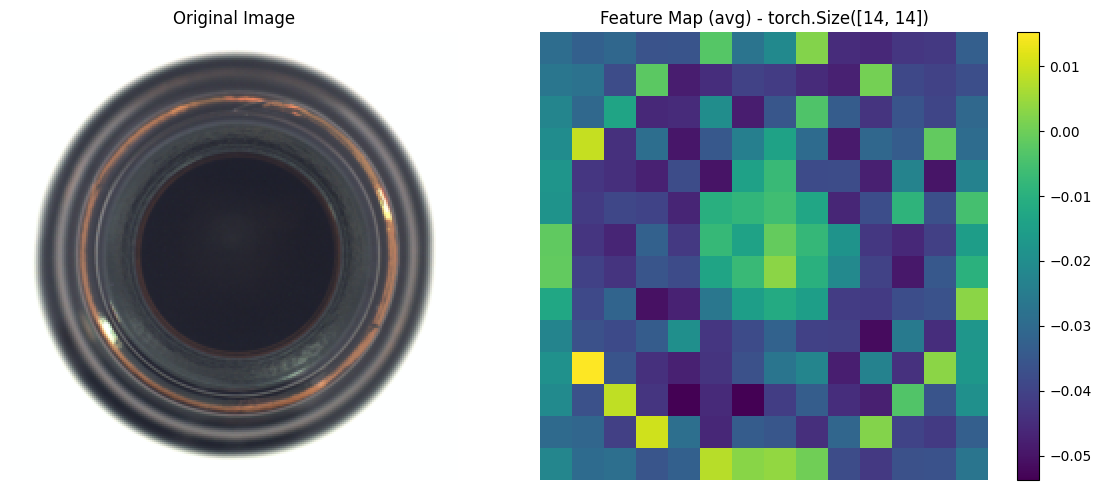


✅ DINOv2 feature extractor ready!
⏰ Completed at: 2025-11-06 12:54:37


In [21]:
# Cell 6: Feature Extractor - DINOv2

from datetime import datetime
import torch.nn.functional as F

class DINOv2FeatureExtractor(nn.Module):
    """DINOv2 Vision Transformer for feature extraction"""
    
    def __init__(self, model_name='dinov2_vitb14', device='cuda'):
        """
        Initialize DINOv2 feature extractor
        Args:
            model_name: Model variant ('dinov2_vitb14', 'dinov2_vits14', 'dinov2_vitl14')
            device: Device to load model on
        """
        super().__init__()
        self.model_name = model_name
        self.device = device
        
        # Load pretrained DINOv2 model from torch hub (with fallback to timm ViT)
        print(f"📥 Loading {model_name} from torch hub...")
        try:
            # Attempt to load the official DINOv2 from torch.hub
            self.model = torch.hub.load('facebookresearch/dinov2', model_name)
            self.model = self.model.to(device)
        except Exception as e:
            # Common cause: HTTP 403 when accessing GitHub raw assets via torch.hub
            print(f"⚠️ Failed to load DINOv2 from torch.hub: {e}")
            print("🔁 Falling back to a pretrained ViT from timm (approximate replacement).")
            try:
                import timm
            except Exception as ie:
                raise RuntimeError(
                    "Failed to load DINOv2 via torch.hub and timm is not installed. "
                    "Install timm in this notebook with: %pip install timm\n"
                    "Or download DINOv2 weights manually and load them."
                ) from ie

            # Create a ViT backbone similar to DINOv2. timm versions may not have vit_base_patch14_224,
            # so try multiple candidates and fall back to any ViT-like model available.
            candidates = [
                'vit_base_patch14_224',
                'vit_base_patch16_224',
                'vit_base_patch14_224_in21k',
                'vit_base_patch16_224_in21k',
                'vit_small_patch16_224',
                'vit_base_patch8_224'
            ]
            chosen = None
            available = timm.list_models()
            for name in candidates:
                if name in available:
                    chosen = name
                    break
            if chosen is None:
                # try to pick first ViT-like model
                vit_models = [m for m in available if ('vit' in m and 'patch' in m)]
                if len(vit_models) == 0:
                    raise RuntimeError(
                        "No ViT models available in timm. Install a newer timm or provide DINOv2 weights."
                    )
                chosen = vit_models[0]

            print(f"🔁 Using timm model '{chosen}' as fallback for DINOv2")
            base = timm.create_model(chosen, pretrained=True, num_classes=0, global_pool='')

            # Infer patch size and embed_dim (may be stored in different attrs)
            patch_size = getattr(base, 'patch_size', None)
            if patch_size is None and hasattr(base, 'patch_embed'):
                pe = getattr(base, 'patch_embed')
                patch_size = getattr(pe, 'patch_size', None)
                if patch_size is None:
                    # some timm versions store proj.stride
                    proj = getattr(pe, 'proj', None)
                    if proj is not None:
                        stride = getattr(proj, 'stride', None)
                        if isinstance(stride, tuple):
                            patch_size = stride[0]
                        elif isinstance(stride, int):
                            patch_size = stride
            if patch_size is None:
                import re
                m = re.search(r'patch(\d+)', chosen)
                patch_size = int(m.group(1)) if m else 14

            embed_dim = getattr(base, 'embed_dim', None) or getattr(base, 'num_features', None) or config.feature_dim

            # Wrap timm model to mimic DINOv2's forward_features API used below.
            class TimmViTWrapper(nn.Module):
                def __init__(self, backbone, embed_dim, patch_size):
                    super().__init__()
                    self.backbone = backbone
                    # provide attributes expected by the rest of the code
                    self.embed_dim = embed_dim
                    self.patch_size = patch_size

                def forward_features(self, x):
                    """
                    Return a dict with key 'x_norm_patchtokens' containing patch tokens:
                      - If backbone.forward_features returns a 4D spatial tensor -> flatten to tokens
                      - If it returns [B, N(+1), C] -> drop cls token if present
                    """
                    feat = None
                    # timm ViT has forward_features, but different timm versions vary
                    if hasattr(self.backbone, 'forward_features'):
                        feat = self.backbone.forward_features(x)
                    else:
                        # fallback to forward (may return logits or features)
                        feat = self.backbone.forward(x)

                    if feat is None:
                        raise RuntimeError("Wrapped timm backbone returned None features.")

                    if feat.dim() == 4:
                        # [B, C, H, W] -> convert to [B, N_patches, C]
                        B, C, H, W = feat.shape
                        tokens = feat.flatten(2).transpose(1, 2)  # [B, N, C]
                        return {'x_norm_patchtokens': tokens}

                    if feat.dim() == 3:
                        # [B, N, C] or [B, N+1, C]; if CLS token exists, drop it
                        if feat.shape[1] > 1:
                            tokens = feat[:, 1:, :] if feat.shape[1] > 1 else feat
                        else:
                            tokens = feat
                        return {'x_norm_patchtokens': tokens}

                    # Last resort: reshape to [B, 1, C]
                    return {'x_norm_patchtokens': feat.unsqueeze(1)}

            self.model = TimmViTWrapper(base, embed_dim, patch_size).to(device)
        
        # Freeze all parameters (no training)
        self.freeze_backbone()
        
        # Set to evaluation mode
        self.model.eval()
        
        # Get model info
        self.feature_dim = self.model.embed_dim

        # Normalize patch_size: some backbones provide an int, others a tuple (h, w).
        # Use the first dimension for compatibility (assume square patches when tuple provided).
        ps = getattr(self.model, 'patch_size', None)
        if isinstance(ps, tuple):
            ps = ps[0]
        if ps is None:
            # fallback to config.patch_size if available
            ps = getattr(config, 'patch_size', None) or 14
        self.patch_size = int(ps)
        
        print(f"✓ Model loaded: {model_name}")
        print(f"  Feature dimension: {self.feature_dim}")
        print(f"  Patch size: {self.patch_size}x{self.patch_size}")
    
    def freeze_backbone(self):
        """Freeze all backbone parameters"""
        for param in self.model.parameters():
            param.requires_grad = False
        print("🔒 Backbone weights frozen")
    
    def forward(self, x):
        """
        Extract patch-level features from input images
        Args:
            x: Input tensor [B, C, H, W]
        Returns:
            features: Patch features [B, N_patches, feature_dim]
        """
        with torch.no_grad():
            # Get patch embeddings from DINOv2
            # DINOv2 returns [CLS token, patch tokens]
            features = self.model.forward_features(x)
            
            # Extract only patch tokens (exclude CLS token)
            patch_features = features['x_norm_patchtokens']
            
            return patch_features
    
    def extract_features(self, dataloader, max_samples=None):
        """
        Extract features from entire dataset
        Args:
            dataloader: PyTorch DataLoader
            max_samples: Maximum number of samples to process (None = all)
        Returns:
            all_features: List of feature tensors
            all_labels: List of labels
        """
        all_features = []
        all_labels = []
        
        self.model.eval()
        with torch.no_grad():
            for batch_idx, batch in enumerate(dataloader):
                if max_samples and batch_idx * dataloader.batch_size >= max_samples:
                    break
                
                images = batch['image'].to(self.device)
                labels = batch['label']
                
                # Extract features
                features = self.forward(images)
                
    def get_num_patches(self, img_size):
        """Calculate number of patches for given image size.
        Supports self.patch_size being int or tuple, and img_size as (H, W) or int.
        """
        # Support integer or (H, W)
        if isinstance(img_size, int):
            h = w = img_size
        else:
            h, w = img_size

        # Support self.patch_size being int or tuple
        ps = self.patch_size
        if isinstance(ps, tuple):
            ps_h, ps_w = ps
        else:
            ps_h = ps_w = ps

        num_patches_h = h // ps_h
        num_patches_w = w // ps_w
        return num_patches_h * num_patches_w
        
        return all_features, all_labels
    
    def get_num_patches(self, img_size):
        """Calculate number of patches for given image size"""
        h, w = img_size
        num_patches_h = h // self.patch_size
        num_patches_w = w // self.patch_size
        return num_patches_h * num_patches_w

# Initialize DINOv2 feature extractor
print("🧠 Initializing DINOv2 feature extractor...")
feature_extractor = DINOv2FeatureExtractor(
    model_name=config.model_name,
    device=config.device
)

# Calculate expected number of patches
num_patches = feature_extractor.get_num_patches(config.img_size)
print(f"\n📐 Patch calculation:")
print(f"  Input size: {config.img_size}")
print(f"  Patch size: {feature_extractor.patch_size}x{feature_extractor.patch_size}")
print(f"  Number of patches: {num_patches}")
print(f"  Feature shape per image: [{num_patches}, {feature_extractor.feature_dim}]")

# Test feature extraction on sample batch
print(f"\n🧪 Testing feature extraction on sample batch...")
sample_batch = next(iter(train_loader))
sample_images = sample_batch['image'].to(config.device)

print(f"  Input shape: {sample_images.shape}")

# Extract features
with torch.no_grad():
    sample_features = feature_extractor(sample_images)

print(f"  Output shape: {sample_features.shape}")
print(f"  Feature dtype: {sample_features.dtype}")
print(f"  Feature range: [{sample_features.min():.3f}, {sample_features.max():.3f}]")

# Visualize feature statistics
print(f"\n📊 Feature statistics:")
print(f"  Mean: {sample_features.mean():.4f}")
print(f"  Std:  {sample_features.std():.4f}")
print(f"  L2 norm (avg): {torch.norm(sample_features, dim=-1).mean():.4f}")

# Memory usage estimation
feature_memory_mb = (num_patches * feature_extractor.feature_dim * 4) / (1024**2)  # 4 bytes per float32
print(f"\n💾 Memory per image: {feature_memory_mb:.2f} MB")
print(f"   Total train features: {len(train_dataset) * feature_memory_mb:.2f} MB")

# Visualize first image and its feature map
sample_img = sample_images[0].cpu()
sample_feat = sample_features[0].cpu()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original image (denormalized)
img_display = sample_img.permute(1, 2, 0).numpy()
img_display = img_display * np.array(config.normalize_std) + np.array(config.normalize_mean)
img_display = np.clip(img_display, 0, 1)
axes[0].imshow(img_display)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Feature map (average across feature dimension)
feat_map = sample_feat.mean(dim=-1).reshape(
    config.img_size[0] // feature_extractor.patch_size,
    config.img_size[1] // feature_extractor.patch_size
)
im = axes[1].imshow(feat_map, cmap='viridis')
axes[1].set_title(f"Feature Map (avg) - {feat_map.shape}")
axes[1].axis('off')
plt.colorbar(im, ax=axes[1])

plt.tight_layout()
plt.show()

print(f"\n✅ DINOv2 feature extractor ready!")
print(f"⏰ Completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

In [22]:
# Cell 7: Memory Bank Construction

from datetime import datetime
from sklearn.random_projection import SparseRandomProjection

class MemoryBank:
    """Memory bank for storing normal sample features"""
    
    def __init__(self, feature_dim, coreset_sampling_ratio=0.1):
        """
        Initialize memory bank
        Args:
            feature_dim: Dimension of feature vectors
            coreset_sampling_ratio: Ratio of features to keep (0.1 = 10%)
        """
        self.feature_dim = feature_dim
        self.coreset_sampling_ratio = coreset_sampling_ratio
        self.memory_bank = None
        self.coreset_indices = None
        
    def build(self, features):
        """
        Build memory bank from training features
        Args:
            features: Training features [N_samples, N_patches, feature_dim]
        """
        print(f"🏗️  Building memory bank...")
        print(f"  Input shape: {features.shape}")
        
        # Flatten to [N_samples * N_patches, feature_dim]
        N_samples, N_patches, feat_dim = features.shape
        features_flat = features.reshape(-1, feat_dim)
        print(f"  Flattened shape: {features_flat.shape}")
        
        # Apply coreset subsampling to reduce memory
        if self.coreset_sampling_ratio < 1.0:
            n_coreset = int(features_flat.shape[0] * self.coreset_sampling_ratio)
            print(f"  Applying coreset subsampling: {features_flat.shape[0]} → {n_coreset}")
            
            # Random sampling for coreset
            self.coreset_indices = np.random.choice(
                features_flat.shape[0], 
                size=n_coreset, 
                replace=False
            )
            self.memory_bank = features_flat[self.coreset_indices].numpy()
        else:
            # Use all features
            self.memory_bank = features_flat.numpy()
            self.coreset_indices = np.arange(features_flat.shape[0])
        
        print(f"  Memory bank size: {self.memory_bank.shape}")
        print(f"  Memory usage: {self.memory_bank.nbytes / (1024**2):.2f} MB")
        
        return self.memory_bank
    
    def get_memory_bank(self):
        """Get memory bank array"""
        return self.memory_bank
    
    def compute_distances(self, query_features, metric='euclidean'):
        """
        Compute distances between query features and memory bank
        Args:
            query_features: Query features [N_query, feature_dim]
            metric: Distance metric ('euclidean' or 'cosine')
        Returns:
            distances: Distance matrix [N_query, N_memory]
        """
        if metric == 'euclidean':
            # Euclidean distance: ||a - b||_2
            distances = torch.cdist(
                torch.from_numpy(query_features).float(),
                torch.from_numpy(self.memory_bank).float(),
                p=2
            )
        elif metric == 'cosine':
            # Cosine distance: 1 - cosine_similarity
            query_norm = F.normalize(torch.from_numpy(query_features).float(), dim=-1)
            memory_norm = F.normalize(torch.from_numpy(self.memory_bank).float(), dim=-1)
            distances = 1 - torch.mm(query_norm, memory_norm.t())
        else:
            raise ValueError(f"Unknown metric: {metric}")
        
        return distances.numpy()
    
    def get_knn_score(self, query_features, k=5, metric='euclidean'):
        """
        Compute k-nearest neighbor anomaly score
        Args:
            query_features: Query features [N_patches, feature_dim]
            k: Number of nearest neighbors
            metric: Distance metric
        Returns:
            anomaly_score: Average distance to k-NN
        """
        # Compute distances to memory bank
        distances = self.compute_distances(query_features, metric=metric)
        
        # Get k smallest distances for each query
        k_nearest_distances = np.partition(distances, k-1, axis=1)[:, :k]
        
        # Anomaly score: mean of k-NN distances
        anomaly_score = k_nearest_distances.mean(axis=1)
        
        return anomaly_score

# Build memory bank for test category
print(f"🎯 Building memory bank for category: {test_category}")
print(f"   Using {len(train_loader.dataset)} training samples")

# Extract features from training set
print(f"\n📊 Extracting features from training set...")
train_features, train_labels = feature_extractor.extract_features(train_loader)

print(f"  Extracted features shape: {train_features.shape}")
print(f"  Feature dtype: {train_features.dtype}")
print(f"  Memory size: {train_features.element_size() * train_features.nelement() / (1024**2):.2f} MB")

# Initialize and build memory bank
memory_bank = MemoryBank(
    feature_dim=config.feature_dim,
    coreset_sampling_ratio=0.1  # Keep 10% of patches
)

memory_bank_array = memory_bank.build(train_features)

# Display memory bank statistics
print(f"\n📈 Memory Bank Statistics:")
print(f"  Total features: {memory_bank_array.shape[0]}")
print(f"  Feature dimension: {memory_bank_array.shape[1]}")
print(f"  Memory usage: {memory_bank_array.nbytes / (1024**2):.2f} MB")
print(f"  Feature mean: {memory_bank_array.mean():.4f}")
print(f"  Feature std: {memory_bank_array.std():.4f}")

# Visualize feature distribution
print(f"\n📊 Visualizing memory bank feature distribution...")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Distribution of first 3 feature dimensions
for i in range(3):
    axes[0].hist(memory_bank_array[:, i], bins=50, alpha=0.5, label=f'Dim {i}')
axes[0].set_xlabel('Feature Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Feature Distribution (first 3 dims)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: L2 norm distribution
l2_norms = np.linalg.norm(memory_bank_array, axis=1)
axes[1].hist(l2_norms, bins=50, color='coral', edgecolor='black')
axes[1].set_xlabel('L2 Norm')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'L2 Norm Distribution (mean: {l2_norms.mean():.2f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Test k-NN scoring on a sample
print(f"\n🧪 Testing k-NN scoring on sample...")
sample_query = train_features[0].numpy()  # First training image
print(f"  Query shape: {sample_query.shape}")

knn_scores = memory_bank.get_knn_score(
    sample_query, 
    k=config.top_k_neighbors,
    metric=config.distance_metric
)

print(f"  k-NN scores shape: {knn_scores.shape}")
print(f"  Score range: [{knn_scores.min():.4f}, {knn_scores.max():.4f}]")
print(f"  Mean score: {knn_scores.mean():.4f}")

# Visualize k-NN scores as heatmap
score_map = knn_scores.reshape(
    config.img_size[0] // feature_extractor.patch_size,
    config.img_size[1] // feature_extractor.patch_size
)

plt.figure(figsize=(6, 6))
plt.imshow(score_map, cmap='hot', interpolation='nearest')
plt.colorbar(label='Anomaly Score')
plt.title(f'k-NN Anomaly Score Map (k={config.top_k_neighbors})')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\n✅ Memory bank constructed successfully!")
print(f"⏰ Completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

🎯 Building memory bank for category: bottle
   Using 4 training samples

📊 Extracting features from training set...


TypeError: cannot unpack non-iterable NoneType object